### Implementing simple Chatbot Using LangGraph with streaming

In [42]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [43]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [44]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant")
llm.invoke("hello")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010365538, 'prompt_time': 0.001595376, 'queue_time': 0.068993684, 'total_time': 0.011960914}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a9dbcb29-6c3a-47e1-9c9a-52d959743ffd-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [45]:
class state(TypedDict):
    messages:Annotated[list,add_messages]

### We Will start With Creating Nodes

In [46]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()
def superbot(state:state):
    return {"messages":[llm.invoke(state["messages"])]}

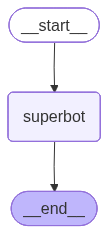

In [47]:
graph=StateGraph(State)
# Node
graph.add_node("superbot",superbot)

#edges
graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)

graph_builder=graph.compile(checkpointer=memory)

#display
from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [48]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi my name is furqan"},config)

{'messages': [HumanMessage(content='Hi my name is furqan', additional_kwargs={}, response_metadata={}, id='8667c6ff-86ca-4c87-b524-c9a9df346f46'),
  AIMessage(content='Nice to meet you, Furqan! How are you today? Is there anything I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 42, 'total_tokens': 72, 'completion_time': 0.043614648, 'prompt_time': 0.019366903, 'queue_time': 5.502013968, 'total_time': 0.062981551}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_31e1ee87c5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a284a8e2-0e0f-48b0-9c0d-61c10cc14e1b-0', usage_metadata={'input_tokens': 42, 'output_tokens': 30, 'total_tokens': 72})]}

### Streaming in LangGraph – Simple Explanation

When running a LangGraph workflow, normally you call `.invoke()` and wait until the entire graph finishes before getting the final result.

But **streaming** lets you get **partial results step by step** as the graph executes. This is useful when you want to show intermediate responses (like live tool outputs or reasoning steps) instead of waiting for everything to finish.

---

### Streaming Methods

| Method       | Type         | Description                                                                                |
| ------------ | ------------ | ------------------------------------------------------------------------------------------ |
| `.stream()`  | Synchronous  | You get results step by step in a loop. Runs in normal Python code.                        |
| `.astream()` | Asynchronous | Same as `.stream()`, but async. Used with `async`/`await`. Good for FastAPI or async apps. |

---

### Streaming Graph State

When streaming, you can choose **what to stream** from the graph:

#### 1. `values`

* Streams the **entire graph state** after each node runs.
* You receive **full state every time**.
* **Use when** you want to see all variables and context at each step.

#### 2. `updates`

* Streams **only what changed** in the state after each node runs.
* You receive **partial updates** only.
* **More efficient** and clean for large graphs.

---

### Example Mental Model

Imagine your graph is running node by node:

```
START → Node A → Node B → Node C → END
```

With streaming:

| After Node | `.stream(values=True)` gets    | `.stream(updates=True)` gets |
| ---------- | ------------------------------ | ---------------------------- |
| Node A     | full state including A results | only A's updates             |
| Node B     | full state including A + B     | only B's updates             |
| Node C     | full state including A + B + C | only C's updates             |

---

### When to Use Which?

| Goal                                  | Stream Option  |
| ------------------------------------- | -------------- |
| Show progress/results step by step    | `.stream()`    |
| Integrate into async server (FastAPI) | `.astream()`   |
| Track everything that happens         | `values=True`  |
| Cleaner and faster state streaming    | `updates=True` |

---

-  **values** : This streams the full state of the graph after each node is called.

In [49]:
for chunk in graph_builder.stream({'messages':"I like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is furqan', additional_kwargs={}, response_metadata={}, id='8667c6ff-86ca-4c87-b524-c9a9df346f46'), AIMessage(content='Nice to meet you, Furqan! How are you today? Is there anything I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 42, 'total_tokens': 72, 'completion_time': 0.043614648, 'prompt_time': 0.019366903, 'queue_time': 5.502013968, 'total_time': 0.062981551}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_31e1ee87c5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a284a8e2-0e0f-48b0-9c0d-61c10cc14e1b-0', usage_metadata={'input_tokens': 42, 'output_tokens': 30, 'total_tokens': 72}), HumanMessage(content='I like football', additional_kwargs={}, response_metadata={}, id='14e26d0a-ef4a-4c35-ad1e-33902eedf7de')]}
{'messages': [HumanMessage(content='Hi my name is furqan', additional_kwargs

In [50]:
for chunk in graph_builder.stream({'messages':"I Love sports "},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is furqan', additional_kwargs={}, response_metadata={}, id='8667c6ff-86ca-4c87-b524-c9a9df346f46'), AIMessage(content='Nice to meet you, Furqan! How are you today? Is there anything I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 42, 'total_tokens': 72, 'completion_time': 0.043614648, 'prompt_time': 0.019366903, 'queue_time': 5.502013968, 'total_time': 0.062981551}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_31e1ee87c5', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a284a8e2-0e0f-48b0-9c0d-61c10cc14e1b-0', usage_metadata={'input_tokens': 42, 'output_tokens': 30, 'total_tokens': 72}), HumanMessage(content='I like football', additional_kwargs={}, response_metadata={}, id='14e26d0a-ef4a-4c35-ad1e-33902eedf7de'), AIMessage(content='Football is a great sport. Which team or league do you sup

- **updates** : This streams updates to the state of the graph after each node is called.


In [51]:
for chunk in graph_builder.stream({'messages':"I also like football "},config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="You're a die-hard football fan, aren't you? Okay, I get it, football is your number one passion! Which aspect of football do you enjoy the most - the tactics, the skills, the teamwork, or the thrill of winning a match?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 195, 'total_tokens': 248, 'completion_time': 0.096007306, 'prompt_time': 0.04097188, 'queue_time': 0.06609295, 'total_time': 0.136979186}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9d5bebb4-fc02-4036-8476-07d4c421e16e-0', usage_metadata={'input_tokens': 195, 'output_tokens': 53, 'total_tokens': 248})]}}


#### Streaming The Responses With astream Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

# Astream example

In [52]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is furqan and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is furqan and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '340544d1-bce7-492a-878c-11d5522ec38c', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is furqan and I like to play cricket', additional_kwargs={}, response_metadata={}, id='f75142fc-4996-4312-ae4a-c5c78e8d20b6')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': 'cbad4932-d2ee-47fc-be21-06591f07332f', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:c1a8eb69-d28c-7c0f-693a-fec23831bedf'}, 'parent_ids': ['340544d1-bce7-492a-878c-11d5522ec38c']}
{'event': 'on_chain_stream', 'run_id': 'cbad4932-d2ee-47fc-be21-06591f07332f', 'name': 'superbot', 'tags': ['graph:step:1']

| Situation                                    | Use `.astream()`? |
| -------------------------------------------- | ----------------- |
| Web app with FastAPI / async backend         | ✅ Yes             |
| Live chat experience                         | ✅ Yes             |
| Handling tool outputs step by step           | ✅ Yes             |
| Building CLI script or Jupyter notebook only | ❌ Use `.stream()` |
| Heavy backend parallel workloads             | ✅ Yes             |
| Multi-user system                            | ✅ Yes             |
| Single simple script                         | ❌ Not needed      |
